In [8]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
eco_rounds = pd.read_csv("../data/vct_2023/matches/eco_rounds.csv")
eco_rounds["Outcome"] = eco_rounds["Outcome"].apply(lambda x: 1 if x == "Win" else 0)
eco_rounds["Loadout Value"] = eco_rounds["Loadout Value"].apply(lambda x: int(x.replace(".","").replace("k","00")))
eco_rounds["Remaining Credits"] = eco_rounds["Remaining Credits"].apply(lambda x: int(x.replace(".","").replace("k","00")))

In [3]:
maps_scores = pd.read_csv("../data/vct_2023/matches/maps_scores.csv")
team_ab_2023 = maps_scores[["Tournament", "Stage", "Match Type", "Match Name", "Map", "Team A", "Team B", "Team A Score", "Team B Score"]]
keys = ['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map','Team']

for i in range(40):
    team_ab_2023 =\
    pd.merge(
        team_ab_2023.rename(columns={"Team A":"Team"})\
        ,eco_rounds[eco_rounds["Round Number"] == i+1].drop(columns="Round Number")\
        ,on=keys
        ,how='left'
    )\
    .rename(columns={"Loadout Value":f"R{i+1}_A_lo", "Remaining Credits":f"R{i+1}_A_rc", "Type":f"R{i+1}_A_et", "Outcome":f"R{i+1}_A_win"})\
    .rename(columns={"Team":"Team A", "Team B":"Team"})\
    .set_index(['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map','Team'])\
    .join(eco_rounds[eco_rounds["Round Number"] == i+1].drop(columns="Round Number")\
        .set_index(['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map','Team'])\
    )\
    .reset_index()\
    .rename(columns={"Loadout Value":f"R{i+1}_B_lo", "Remaining Credits":f"R{i+1}_B_rc", "Type":f"R{i+1}_B_et", "Outcome":f"R{i+1}_B_win"})\
    .rename(columns={"Team":"Team B"})\

team_ab_2023["Team_A_win"] = (team_ab_2023["Team A Score"] - team_ab_2023["Team B Score"]) > 0
team_ab_2023["Team_B_win"] = (team_ab_2023["Team B Score"] - team_ab_2023["Team A Score"]) > 0

In [11]:
j=team_ab_2023[team_ab_2023.R1_A_win.isna()==False]
j['total_rounds'] = j['Team A Score'] + j['Team B Score']


C:\Users\swamp\AppData\Local\Temp\ipykernel_17984\2092538396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j['total_rounds'] = j['Team A Score'] + j['Team B Score']


mean of true values: 0.4838709677419355
mean of predicted values: 0.5032258064516129
accuracy: 0.7483870967741936
coefficients: [[1.21112434 0.484979   0.82905451 0.51395797 1.08171756 0.34028077
  0.71506158 0.78007553 0.60058408 0.88476096 0.7116609  0.6561633
  1.51746362]]


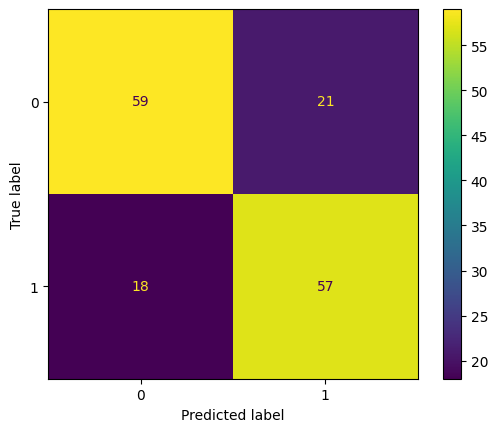

In [20]:

pred_cols = [f"R{i+1}_A_win" for i in range(13)]

X = j[pred_cols]
y = j['Team_A_win']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True, stratify=y, random_state=42)

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
train_pred=model.predict(X_train)
acc = accuracy_score(y_test,y_pred)
print("mean of true values:",y_test.mean())
print("mean of predicted values:",y_pred.mean())
print("accuracy:",acc)
print("coefficients:",model.coef_)

cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [19]:
data = pd.DataFrame({'accuracy':[acc]})
data

,accuracy
0,0.748387


In [24]:
analysis_dictionary = {\
    "mean_y_train":[],
    "mean_y_test":[],
    "mean_train_pred":[],
    "mean_test_pred":[],
    "train_acc":[],
    "test_acc" :[],
    "coefficients":[]
    }\

analysis_dictionary["mean_y_train"].append(np.mean(y_train))
analysis_dictionary["mean_y_test"].append(np.mean(y_test))
analysis_dictionary["mean_train_pred"].append(np.mean(train_pred))
analysis_dictionary["mean_test_pred"].append(np.mean(y_pred))
analysis_dictionary["train_acc"].append(accuracy_score(y_train, train_pred))
analysis_dictionary["test_acc"].append(accuracy_score(y_test, y_pred))
analysis_dictionary["coefficients"].append(np.round(model.coef_,2))

analysis_dictionary

{'mean_y_train': [0.5211038961038961],
 'mean_y_test': [0.4838709677419355],
 'mean_train_pred': [0.5405844155844156],
 'mean_test_pred': [0.5032258064516129],
 'train_acc': [0.788961038961039],
 'test_acc': [0.7483870967741936],
 'coefficients': [array([[1.21, 0.48, 0.83, 0.51, 1.08, 0.34, 0.72, 0.78, 0.6 , 0.88, 0.71,
          0.66, 1.52]])]}

In [40]:
analysis_dictionary = {\
        "rounds_seen":[],
        "mean_y_train":[],
        "mean_y_test":[],
        "mean_train_pred":[],
        "mean_test_pred":[],
        "train_acc":[],
        "test_acc" :[],
        "coefficients":[]
        }\

analysis_df = pd.DataFrame()

for i in range(1,14):
    pred_cols = [f"R{j}_A_win" for j in range(1,i+1)]
    
    X = j[pred_cols]
    y = j['Team_A_win']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True, stratify=y, random_state=42)

    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    train_pred=model.predict(X_train)


    
    analysis_dictionary["rounds_seen"].append(i)
    analysis_dictionary["mean_y_train"].append(np.mean(y_train))
    analysis_dictionary["mean_y_test"].append(np.mean(y_test))
    analysis_dictionary["mean_train_pred"].append(np.mean(train_pred))
    analysis_dictionary["mean_test_pred"].append(np.mean(y_pred))
    analysis_dictionary["train_acc"].append(accuracy_score(y_train, train_pred))
    analysis_dictionary["test_acc"].append(accuracy_score(y_test, y_pred))
    analysis_dictionary["coefficients"].append(np.round(model.coef_[0],2))


for feature_name, lst in analysis_dictionary.items():
    analysis_df[feature_name] = lst

analysis_df

,rounds_seen,mean_y_train,mean_y_test,mean_train_pred,mean_test_pred,train_acc,test_acc,coefficients
0,1,0.512987,0.516129,0.483766,0.548387,0.629870,0.619355,[1.04]
1,2,0.512987,0.516129,0.469156,0.522581,0.657468,0.593548,"[0.22, 1.12]"
2,3,0.512987,0.516129,0.472403,0.529032,0.663961,0.600000,"[0.57, 0.97, 0.93]"
3,4,0.512987,0.516129,0.496753,0.522581,0.649351,0.567742,"[0.48, 0.93, 0.79, 0.83]"
4,5,0.512987,0.516129,0.514610,0.516129,0.670455,0.638710,"[0.66, 0.85, 0.81, 0.67, 0.96]"
5,6,0.512987,0.516129,0.521104,0.529032,0.676948,0.638710,"[0.59, 0.91, 0.82, 0.7, 0.88, 0.66]"
6,7,0.512987,0.516129,0.524351,0.522581,0.706169,0.683871,"[0.65, 0.82, 0.83, 0.64, 0.89, 0.55, 0.55]"
7,8,0.512987,0.516129,0.517857,0.509677,0.719156,0.670968,"[0.79, 0.75, 0.82, 0.63, 0.89, 0.51, 0.47, 0.97]"
8,9,0.512987,0.516129,0.534091,0.516129,0.722403,0.677419,"[0.75, 0.77, 0.81, 0.61, 0.9, 0.44, 0.47, 0.87, 0.71]"
9,10,0.512987,0.516129,0.524351,0.535484,0.764610,0.709677,"[0.77, 0.75, 0.8, 0.57, 0.92, 0.47, 0.44, 0.88, 0.58, 0.77]"


In [39]:
pd.set_option("display.max_colwidth",100)

In [41]:
analysis_dictionary = {\
        "rounds_seen":[],
        "mean_y_train":[],
        "mean_y_test":[],
        "mean_train_pred":[],
        "mean_test_pred":[],
        "train_acc":[],
        "test_acc" :[],
        "coefficients":[]
        }\

analysis_df = pd.DataFrame()

for i in range(1,14):
    pred_cols = [f"R{j}_A_win" for j in range(1,i+1)]
    
    X = j[pred_cols]
    y = j['Team_A_win']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True, stratify=y, random_state=42)

    model = LogisticRegression(random_state=42,fit_intercept=False)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    train_pred=model.predict(X_train)


    
    analysis_dictionary["rounds_seen"].append(i)
    analysis_dictionary["mean_y_train"].append(np.mean(y_train))
    analysis_dictionary["mean_y_test"].append(np.mean(y_test))
    analysis_dictionary["mean_train_pred"].append(np.mean(train_pred))
    analysis_dictionary["mean_test_pred"].append(np.mean(y_pred))
    analysis_dictionary["train_acc"].append(accuracy_score(y_train, train_pred))
    analysis_dictionary["test_acc"].append(accuracy_score(y_test, y_pred))
    analysis_dictionary["coefficients"].append(np.round(model.coef_[0],2))


for feature_name, lst in analysis_dictionary.items():
    analysis_df[feature_name] = lst

analysis_df

,rounds_seen,mean_y_train,mean_y_test,mean_train_pred,mean_test_pred,train_acc,test_acc,coefficients
0,1,0.512987,0.516129,0.483766,0.548387,0.629870,0.619355,[0.6]
1,2,0.512987,0.516129,0.469156,0.522581,0.657468,0.593548,"[-0.12, 0.86]"
2,3,0.512987,0.516129,0.751623,0.761290,0.612013,0.574194,"[-0.13, 0.82, 0.07]"
3,4,0.512987,0.516129,0.699675,0.735484,0.650974,0.612903,"[-0.23, 0.79, -0.07, 0.33]"
4,5,0.512987,0.516129,0.813312,0.851613,0.628247,0.587097,"[-0.24, 0.76, -0.12, 0.27, 0.19]"
5,6,0.512987,0.516129,0.808442,0.832258,0.629870,0.580645,"[-0.22, 0.76, -0.1, 0.27, 0.22, -0.07]"
6,7,0.512987,0.516129,0.808442,0.832258,0.629870,0.580645,"[-0.22, 0.76, -0.1, 0.27, 0.22, -0.07, -0.01]"
7,8,0.512987,0.516129,0.837662,0.864516,0.587662,0.561290,"[-0.23, 0.74, -0.15, 0.25, 0.19, -0.09, -0.05, 0.21]"
8,9,0.512987,0.516129,0.852273,0.864516,0.582792,0.561290,"[-0.25, 0.74, -0.16, 0.25, 0.18, -0.11, -0.06, 0.19, 0.1]"
9,10,0.512987,0.516129,0.855519,0.883871,0.589286,0.541935,"[-0.26, 0.74, -0.18, 0.23, 0.17, -0.12, -0.07, 0.17, 0.07, 0.16]"
